In [1]:
import sys 
sys.path.append('../')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pysr import PySRRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from gplearn.genetic import SymbolicRegressor
from sympy import *

In [3]:
%load_ext autoreload
%autoreload 2
from relation import Distribution
from relation import Analysis

In [4]:
a = Analysis(50,'140','')

In [5]:
a.distribution.z

0.032637493

In [6]:
df = a.get_dataframe()

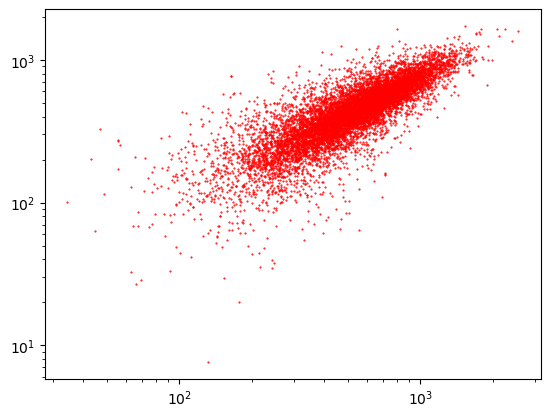

In [7]:
plt.loglog(df['Vnet'],df['vnet'],'r.',markersize=1)

In [8]:
np.corrcoef(df['Vnet'],df['vnet'])

array([[1.        , 0.84264093],
       [0.84264093, 1.        ]])

In [9]:
train_df, test_df = train_test_split(df, train_size=0.3, random_state=42)

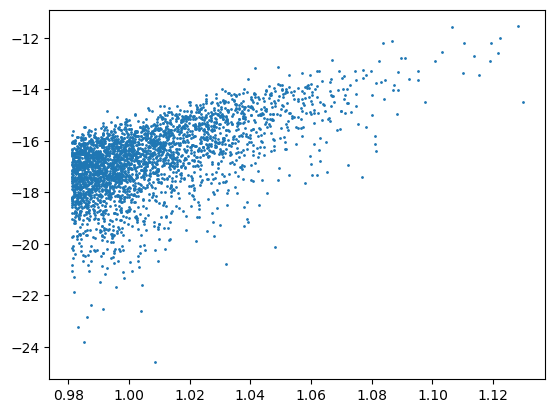

In [10]:
plt.scatter(train_df['M']/np.median(train_df['M']),train_df['Y'],s=1)

In [11]:
def get_inp(features):
    xlen = len(features[0])
    ylen = len(features)
    inp = np.zeros((xlen,ylen))
    for i in range(len(features)):
        inp[:,i] = features[i]
    return inp

In [12]:
inp1 = get_inp([train_df['M']])
inp2 = get_inp([np.log(train_df['Mstar'])])
inp3 = get_inp([train_df['Vnet']])
inp4 = get_inp([np.log(train_df['Mstar']),train_df['Vnet']])

In [13]:
Y = train_df['Y']
Y_prime = Y/train_df['M']

In [14]:
regr = RandomForestRegressor(max_depth=50,max_leaf_nodes=5, random_state=0,n_estimators=50,n_jobs=-1)
regr.fit(inp1, Y)

RandomForestRegressor(max_depth=50, max_leaf_nodes=5, n_estimators=50,
                      n_jobs=-1, random_state=0)

In [15]:
Y_prime2 = Y/regr.predict(inp1)

In [16]:
regr2 = RandomForestRegressor(max_depth=50,max_leaf_nodes=5, random_state=0,n_estimators=50,n_jobs=-1)
regr2.fit(inp2, Y_prime)

RandomForestRegressor(max_depth=50, max_leaf_nodes=5, n_estimators=50,
                      n_jobs=-1, random_state=0)

In [17]:
regr3 = RandomForestRegressor(max_depth=50, max_leaf_nodes=5,random_state=0,n_estimators=50,n_jobs=-1)
regr3.fit(inp3, Y_prime)

RandomForestRegressor(max_depth=50, max_leaf_nodes=5, n_estimators=50,
                      n_jobs=-1, random_state=0)

In [18]:
regr4 = RandomForestRegressor(max_depth=50, max_leaf_nodes=5,random_state=0,n_estimators=50,n_jobs=-1)
regr4.fit(inp4, Y_prime)

RandomForestRegressor(max_depth=50, max_leaf_nodes=5, n_estimators=50,
                      n_jobs=-1, random_state=0)

In [19]:
regr4.feature_importances_

array([0.92136195, 0.07863805])

In [20]:
model = PySRRegressor(
    niterations=20,
    maxsize=10,
    maxdepth=10,
    binary_operators=["+", "-", "*", "/",'pow',],
    unary_operators=["neg","exp","log","sqrt",],
    procs=4,
    model_selection="best",)
model.fit(inp1,Y,weights=train_df['M']**.5)

/home/anto/Softwares/anaconda3/lib/python3.8/site-packages/pysr/sr.py:1257: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Started!

Cycles per second: 1.610e+04
Head worker occupation: 7.0%
Progress: 45 / 300 total iterations (15.000%)
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           1.992e+00  1.855e-06  -16.706606
3           1.302e+00  2.124e-01  (x0 - 47.436996)
6           1.289e+00  3.552e-03  ((sqrt(x0) + x0) - 52.980556)
8           1.285e+00  1.326e-03  ((sqrt(x0 + x0) + x0) - 55.276104)
10          1.285e+00  3.559e-05  ((sqrt((x0 - 1.1999222) + x0) + x0) - 55.198883)

Press 'q' and then <enter> to stop execution early.

Cycles per second: 1.760e+04
Head worker occupation: 2.4%
Progress: 98 / 300 total iterations (32.667%)
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           1.992e+00  2.095e-06  -16.707329
3           1.302e+00  2.124e-01  (x0 - 47.437057)
6           1.289e+00  3.551e-03  ((sqrt(x0) + x0) - 52.980556)
8           1.285e+00  1.326e-03  ((sqrt(x0 + x0) + x0) - 55

PySRRegressor.equations_ = [
	   pick         score                                           equation  \
	0        0.000000e+00                                         -16.707329   
	1  >>>>  2.124187e-01                                   (x0 - 47.437057)   
	2        7.725951e-03                     ((x0 * 1.2016358) - 53.633575)   
	3        5.848206e-08  (((x0 + (0.017754583 / x0)) * 1.2016358) - 53....   
	4        4.725463e-05  ((((sqrt(x0) * 24.599554) - x0) + -61.115547) ...   
	
	       loss  complexity  
	0  1.991837           1  
	1  1.302415           3  
	2  1.282445           5  
	3  1.282444           9  
	4  1.282384          10  
]

In [21]:
Y_primes = Y/model.predict(inp1)

In [22]:
model1 = PySRRegressor(
    niterations=20,
    maxsize=10,
    maxdepth=10,
    binary_operators=["+", "-", "*", "/",'pow',],
    unary_operators=["neg","exp","log","sqrt",],
    procs=4,
    model_selection="best",)
model1.fit(inp2,Y_primes,weights=train_df['M']**.5)

/home/anto/Softwares/anaconda3/lib/python3.8/site-packages/pysr/sr.py:1257: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Started!

Cycles per second: 1.610e+04
Head worker occupation: 0.6%
Progress: 46 / 300 total iterations (15.333%)
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           4.685e-03  1.392e-06  0.9996168
3           4.685e-03  2.772e-06  (x0 ^ -0.00016294773)
4           4.641e-03  9.445e-03  sqrt(27.341019 / x0)

Press 'q' and then <enter> to stop execution early.

Cycles per second: 1.450e+04
Head worker occupation: 0.6%
Progress: 86 / 300 total iterations (28.667%)
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           4.685e-03  1.392e-06  0.9996168
3           4.685e-03  4.232e-06  (x0 ^ -0.00015389819)
4           4.641e-03  9.443e-03  sqrt(27.341019 / x0)
5           4.628e-03  2.782e-03  sqrt(sqrt(27.341019 / x0))
6           4.624e-03  7.341e-04  (sqrt(27.341019 / x0) ^ 0.6662553)

Press 'q' and then <enter> to stop execution early.

Cycles per second: 1.440e+04
Head work

PySRRegressor.equations_ = [
	   pick     score                            equation      loss  complexity
	0        0.000000                           0.9996168  0.004685           1
	1        0.000018                   (0.99997747 ^ x0)  0.004684           3
	2  >>>>  0.009415                 sqrt(27.34101 / x0)  0.004641           4
	3        0.002781          sqrt(sqrt(27.341022 / x0))  0.004628           5
	4        0.000737  sqrt((27.341019 / x0) ^ 0.6558157)  0.004624           6
]

In [23]:
model2 = PySRRegressor(
    niterations=20,
    maxsize=10,
    maxdepth=10,
    binary_operators=["+", "-", "*", "/",'pow',],
    unary_operators=["neg","exp","log","sqrt",],
    procs=4,
    model_selection="best",)
model2.fit(inp3,Y_primes,weights=train_df['M']**.5)

/home/anto/Softwares/anaconda3/lib/python3.8/site-packages/pysr/sr.py:1257: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Started!

Cycles per second: 1.520e+04
Head worker occupation: 0.7%
Progress: 42 / 300 total iterations (14.000%)
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           4.685e-03  1.392e-06  0.9996168
4           4.515e-03  1.231e-02  exp(4.7128873 / x0)
5           4.380e-03  3.027e-02  exp(0.7816449 ^ sqrt(x0))
7           4.371e-03  1.083e-03  sqrt(sqrt(sqrt(exp(0.99274904 ^ x0))))
8           4.202e-03  3.930e-02  sqrt(sqrt(exp(0.99274904 ^ x0) / 1.0528436))
9           3.956e-03  6.043e-02  ((x0 + -10344.042) / ((x0 - x0) + -9772.659))

Press 'q' and then <enter> to stop execution early.

Cycles per second: 1.700e+04
Head worker occupation: 0.9%
Progress: 94 / 300 total iterations (31.333%)
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           4.685e-03  1.392e-06  0.9996168
4           4.515e-03  1.231e-02  exp(4.7129273 / x0)
5           4.380e-03  3.027e-02  exp(0.7816

PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                          0.9996168   
	1        0.000700                               (x0 ^ -0.0004912264)   
	2        0.035526                                 exp(4.712951 / x0)   
	3  >>>>  0.134819                    (-10129.191 / (-9562.382 - x0))   
	4        0.000132      ((-10344.042 / (-9772.659 - x0)) ^ 1.0729246)   
	5        0.000064  (-10344.042 / ((-9772.659 - x0) - (-9772.659 /...   
	6        0.000028  ((-10344.042 / ((-9772.659 - log(x0)) - x0)) ^...   
	
	       loss  complexity  
	0  0.004685           1  
	1  0.004678           3  
	2  0.004515           4  
	3  0.003945           5  
	4  0.003944           7  
	5  0.003944           9  
	6  0.003944          10  
]

In [24]:
model3 = PySRRegressor(
    niterations=20,
    maxsize=10,
    maxdepth=10,
    binary_operators=["+", "-", "*", "/",'pow',],
    unary_operators=["neg","exp","log","sqrt",],
    procs=4,
    model_selection="best",)
model3.fit(inp4,Y_primes,weights=train_df['M']**.5)

/home/anto/Softwares/anaconda3/lib/python3.8/site-packages/pysr/sr.py:1257: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Started!

Cycles per second: 1.900e+04
Head worker occupation: 1.9%
Progress: 54 / 300 total iterations (18.000%)
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           4.685e-03  1.392e-06  0.9996168
3           4.680e-03  4.486e-04  (x1 ^ -0.00016485435)
4           4.515e-03  3.603e-02  exp(4.7129374 / x1)
5           4.422e-03  2.088e-02  exp(0.76063544 ^ sqrt(x1))
7           4.366e-03  6.347e-03  (exp(sqrt(x0) / x1) - 0.012375008)
8           4.322e-03  1.002e-02  exp(log(x0 / sqrt(x1)) / x0)
9           4.259e-03  1.467e-02  (exp(sqrt(x0) / (x1 ^ 0.9134177)) - 0.017082633)
10          4.235e-03  5.714e-03  exp(log((x0 / sqrt(x1)) - 0.14483538) / x0)

Press 'q' and then <enter> to stop execution early.

Cycles per second: 1.570e+04
Head worker occupation: 1.5%
Progress: 90 / 300 total iterations (30.000%)
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           4.685e-03  1

PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                          0.9996168   
	1        0.014642                                    (0.999984 ^ x1)   
	2        0.007641                                exp(4.7129374 / x1)   
	3        0.048509                   ((0.9999681 ^ x1) + 0.017361585)   
	4        0.005534                   (((x0 * x0) / x1) ^ 0.037889045)   
	5        0.002891                (sqrt((x0 * x0) / x1) ^ 0.06855952)   
	6  >>>>  0.057986  (((x1 / 1.2694203) ^ (x1 ^ -0.69441396)) - 0.0...   
	
	       loss  complexity  
	0  0.004685           1  
	1  0.004549           3  
	2  0.004515           4  
	3  0.004301           5  
	4  0.004254           7  
	5  0.004241           8  
	6  0.004002           9  
]

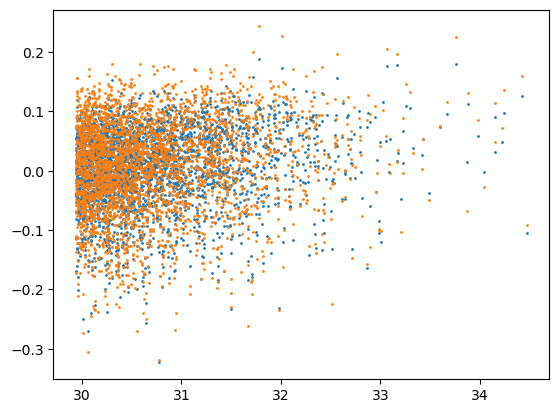

In [30]:
plt.scatter(train_df['M'],model.predict(inp1)/Y -1,s=1,label='PySR[M]')
#plt.scatter(train_df['M'],(model.predict(inp1)/model1.predict(inp2))/Y -1,s=1,label='PySR[M,M*]')
#plt.scatter(train_df['M'],(model.predict(inp1)/model2.predict(inp3))/Y -1,s=1,label='PySR[M,M*]')
plt.scatter(train_df['M'],(model.predict(inp1)/model3.predict(inp4))/Y -1,s=1,label='PySR[M,M*]')
#plt.scatter(train_df['M'],train_df['M']*1.2*model3.predict(inp_3)/Y -1,s=1,label='PySR[M,M*,d_ng]')